## AMAZON FINE FOOD REVIEWS : GRADIENT BOOSTED DECISION TREES

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


**DATA SET SPLITS ** 

1. AVG_WORD2VEC : 70K TRAIN,  30K TEST
2. TFIDF_WORD2VEC : 70K TRAIN ,  30K TEST
3. BOW : 60K TRAIN,  20K CV,  20K TEST
4. TFIDF : 60K TRAIN, 20K CV,  20K TEST

In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score,roc_auc_score,precision_score, recall_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from scipy.sparse import vstack
import operator
import wordcloud
import sklearn.metrics as metrics
import collections
import plotly as py
import plotly.graph_objs  as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [0]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          13022         403       11244           0        1374       12354
Swap:             0           0           0


In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

** MOUNTING GOOGLE DRIVE TO GET THE DATA **

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## FEATURISATION  1: BOW 

In [0]:
bow_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/train_bow.sav','rb'))
bow_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/cv_bow.sav','rb'))
bow_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/test_bow.sav','rb'))
y_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_train.sav','rb'))
y_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_test.sav','rb'))
y_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_cv.sav','rb'))
bow = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/BOW.sav','rb'))

** APPROACH : **

1. First run a simple cross validation of the increasing the number of estimators by the multiples of 5 and see the improvement in the scoring metric for BOW and narrow down the range of estimators to perfrom grid search for different parameters.

2. Scoring metrics used : RECALL ,PRECISION  for negative class and AUC 
3. We also need to examine the train test error difference to see the intensity of overfit as N-estimators increase.


** Constants : **

1. max_depth = 5
2. colsample_bytree = 1
3. booster =  gbtree
4. learning rate = 0.07
5. objective = binay : logistic 
6. eval_metric = auc 


In [0]:
recall = {}
precision = {}
train_error = {}
test_error = {}
auc = {}

for i in [25,50,75,100,125,150,175,200,225,250,275,300]:
  print("Training for n_estimators = " + str(i) + "\n")
  model = xgb.XGBClassifier(max_depth = 5,n_estimators = i,booster = 'gbtree',colsample_bytree=1,learning_rate = 0.07,objective = 'binary:logistic',eval_metric = 'auc')
  model.fit(bow_train,y_train)
  pred = model.predict(bow_cv)
  test_error[i] = (1 - accuracy_score(y_true = y_cv,y_pred=pred)) * 100
  train_error[i] = (1 - accuracy_score(y_true = y_train,y_pred=model.predict(bow_train))) * 100
  recall[i] = recall_score(y_true = y_cv,y_pred = pred,pos_label = 0) * 100
  precision[i] = precision_score(y_true =y_cv,y_pred = pred,pos_label = 0) * 100 
  auc[i] = roc_auc_score(y_true = y_cv,y_score = pred)

Training for n_estimators = 25

Training for n_estimators = 50

Training for n_estimators = 75

Training for n_estimators = 100

Training for n_estimators = 125

Training for n_estimators = 150

Training for n_estimators = 175

Training for n_estimators = 200

Training for n_estimators = 225

Training for n_estimators = 250

Training for n_estimators = 275

Training for n_estimators = 300



 ** TRAIN AND CV ERRORS  ** 

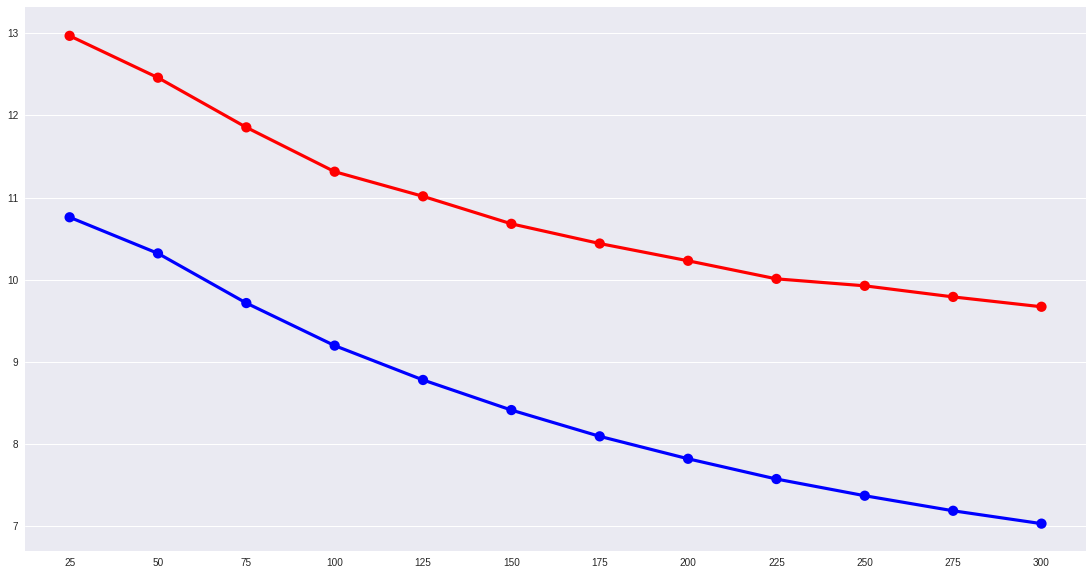

In [0]:
plt.figure(figsize = (19,10))
sns.pointplot(list(train_error.keys()),list(train_error.values()),color = 'blue')
sns.pointplot(list(test_error.keys()),list(test_error.values()),color = 'red')
plt.legend(('blue','red'),('Test_error','Train_error'))

** RECALL OF TRAIN AND CV ** 

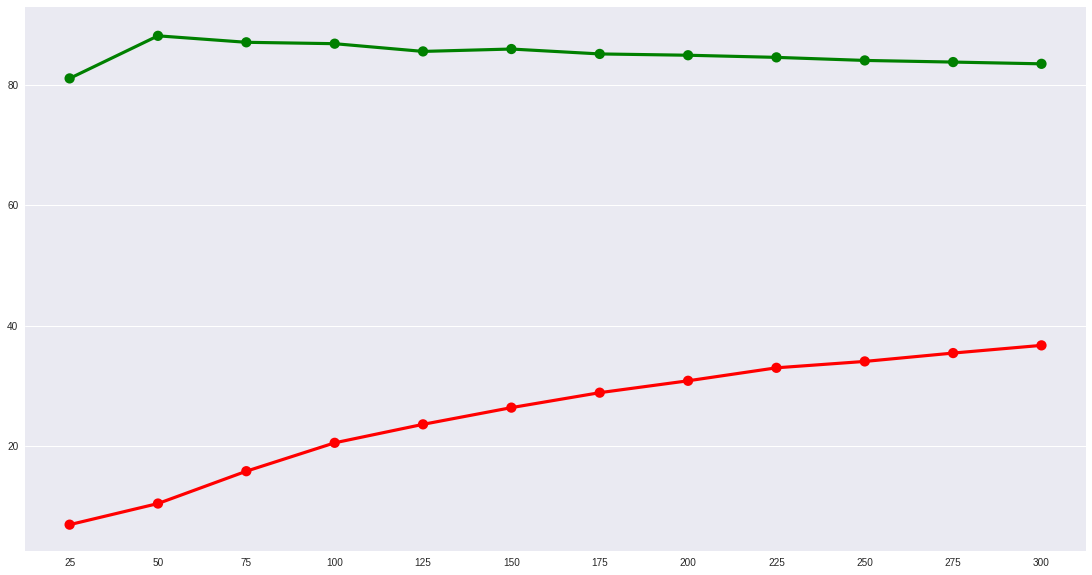

In [0]:
plt.figure(figsize = (19,10))
sns.pointplot(list(recall.keys()),list(recall.values()),color = 'red')
sns.pointplot(list(precision.keys()),list(precision.values()),color = 'green')
plt.legend(('blue','red'),('Test_error','Train_error'))

** AUC SCORE ** 

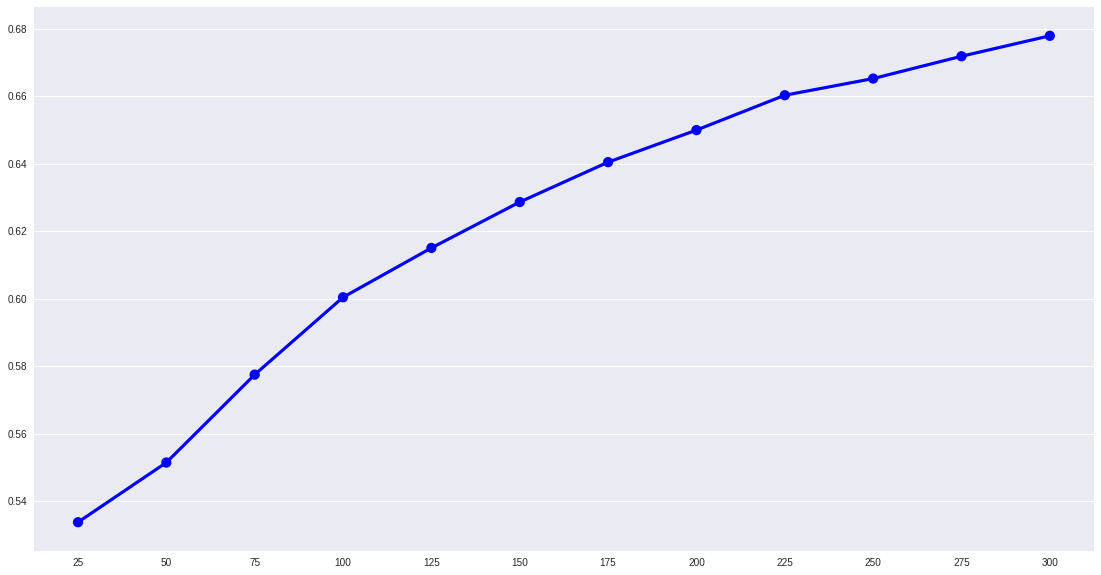

In [0]:
plt.figure(figsize = (19,10))
sns.pointplot(list(auc.keys()),list(auc.values()),color = 'blue')

** Observations  : ** 

1. The bias is considerably reducing  i.e the maginitude of train error and test error are reducing  as the N-estimators are increased. 
2. The margin of difference between train and test does not widen as the N-estimators increase till 300. 
3. The ideal thing is to perform grid search with above range of n_estimators

<br>
<br>
** PERFORMING GRID SEARCH **

** PARAM GRID : ** 

Constants:
1. Booster : Gbtree
2. eval-metric : auc

Variables: 

1. Learning Rate
2. max Depth 
3. N_estimators : 100,125,150,175,200,225,250,275,300
4. colsample_bytree 

In [0]:
params = {'learning_rate':[0.05,0.1,0.2],'max_depth':[4,5,6],'n_estimators':[100,125,150,175,200,225,250,275,300],'colsample_bytree':[0.5,0.75]}

In [0]:
gridModel = GridSearchCV(estimator = xgb.XGBClassifier(booster = 'gbtree',eval_metric = 'auc'),param_grid = params,n_jobs =-1,scoring='roc_auc',verbose=True,cv = 2)

In [0]:
gridModel.fit(X_train,Y_train)

Fitting 2 folds for each of 162 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 80.7min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [4, 5, 6], 'n_estimators': [100, 125, 150, 175, 200, 225, 250, 275, 300], 'colsample_bytree': [0.5, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [0]:
#best auc score 
gridModel.best_score_

0.9281085840189383

In [0]:
#best params 
gridModel.best_params_

{'colsample_bytree': 0.75,
 'learning_rate': 0.2,
 'max_depth': 5,
 'n_estimators': 300}

** Preparing the dataframe for visualisaiton ** 

In [0]:
results = pd.DataFrame(gridModel.cv_results_['params'])

In [0]:
results['Train_AUC_SCORE'] = gridModel.cv_results_['mean_train_score']
results['Test_AUC_SCORE'] = gridModel.cv_results_['mean_test_score']

** Analysis and visualisation of influence of various parameters on the AUC score ** 

** HEATMAP : TEST_AUC_SCORE **

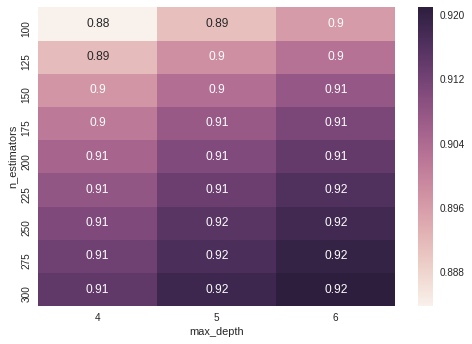

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Test_AUC_SCORE"),annot= True)

** HEATMAP : TRAIN_AUC_SCORE ** 

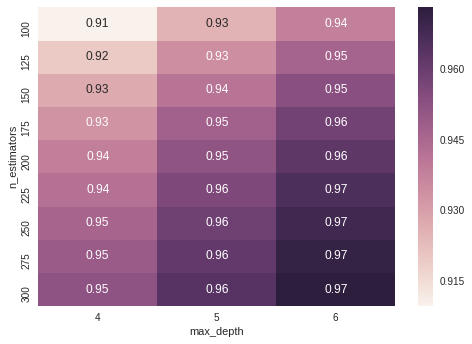

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Train_AUC_SCORE"),annot= True)

** IMPACT OF COLUMN SAMPLING AND LEARNING RATE ** 

In [0]:
results.groupby('learning_rate').aggregate(np.mean)[['Train_AUC_SCORE','Test_AUC_SCORE']]

,Train_AUC_SCORE,Test_AUC_SCORE
learning_rate,,
0.05,0.923623,0.890930
0.10,0.950277,0.910610
0.20,0.969798,0.921434


In [0]:
results.groupby('colsample_bytree').aggregate(np.mean)[['Train_AUC_SCORE','Test_AUC_SCORE']]

,Train_AUC_SCORE,Test_AUC_SCORE
colsample_bytree,,
0.50,0.947354,0.907797
0.75,0.948445,0.907519


In [0]:
#prediciting for test values 
pred = gridModel.predict(bow_test)

In [0]:
tpred = gridModel.predict(X_train)

In [0]:
print(classification_report(y_true = y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.82      0.50      0.62      2674
           1       0.93      0.98      0.95     17326

   micro avg       0.92      0.92      0.92     20000
   macro avg       0.87      0.74      0.79     20000
weighted avg       0.91      0.92      0.91     20000



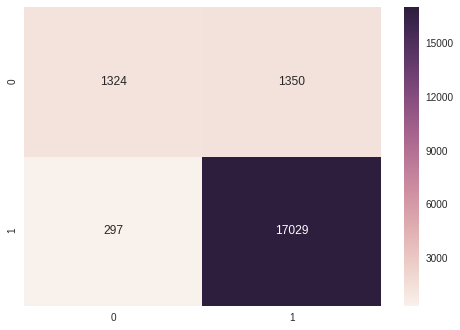

In [0]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred=pred),annot= True,fmt='d')

In [0]:
print("TRAIN ERROR : " + str(1-(accuracy_score(y_true = Y_train,y_pred=tpred))))

TRAIN ERROR : 0.0531625


In [0]:
print("TEST ERROR : " + str(1-(accuracy_score(y_true = y_test,y_pred=pred))))

TEST ERROR : 0.08235000000000003


** Observations ** 

1. There is 3 % difference between the train and test error.
2. The recall for negative reviews and  precision are considerably high.
3. Final model : Grid Search best params : max Depth : 5 , n estimators 300

In [0]:
model = xgb.XGBClassifier(max_depth = 5,n_estimators = 300,booster = 'gbtree',colsample_bytree=0.75,learning_rate = 0.2,objective = 'binary:logistic',eval_metric = 'auc') 
model.fit(X_train,Y_train)
pred = model.predict(bow_test)

In [0]:
tpred = model.predict(X_train)

In [0]:
print(classification_report(y_true = y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.82      0.50      0.62      2674
           1       0.93      0.98      0.95     17326

   micro avg       0.92      0.92      0.92     20000
   macro avg       0.87      0.74      0.79     20000
weighted avg       0.91      0.92      0.91     20000



** CONFUSION MATRIC : TEST  SET ** 

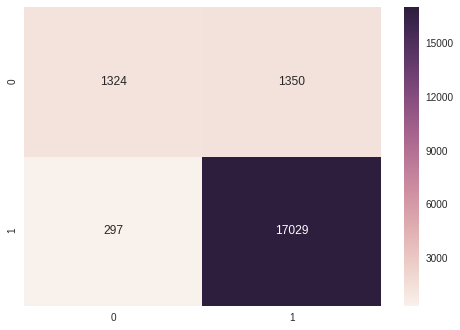

In [0]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred=pred),annot= True,fmt='d')

** CONFUSION MATRIX : TRAIN SET **

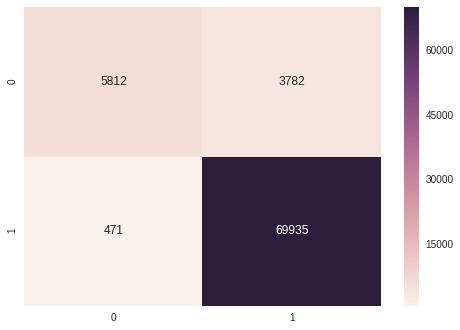

In [0]:
sns.heatmap(confusion_matrix(y_pred =tpred,y_true = Y_train),annot= True,fmt='d')

In [0]:
print("TRAIN ERROR : " + str(1-(accuracy_score(y_true = Y_train,y_pred=tpred))))

TRAIN ERROR : 0.0531625


In [0]:
print("TEST ERROR : " + str(1-(accuracy_score(y_true = y_test,y_pred=pred))))

TEST ERROR : 0.08235000000000003


<br>
<br>
** FEATURE IMPORTANCE  : BAG OF WORDS **

In [0]:
features = bow.get_feature_names()

In [0]:
f_imp = dict(zip(features,model.feature_importances_))

In [0]:
top_20 = {}
for i in sorted(f_imp.items(), key=operator.itemgetter(1),reverse= True)[:20]:
  top_20[i[0]] = i[1]

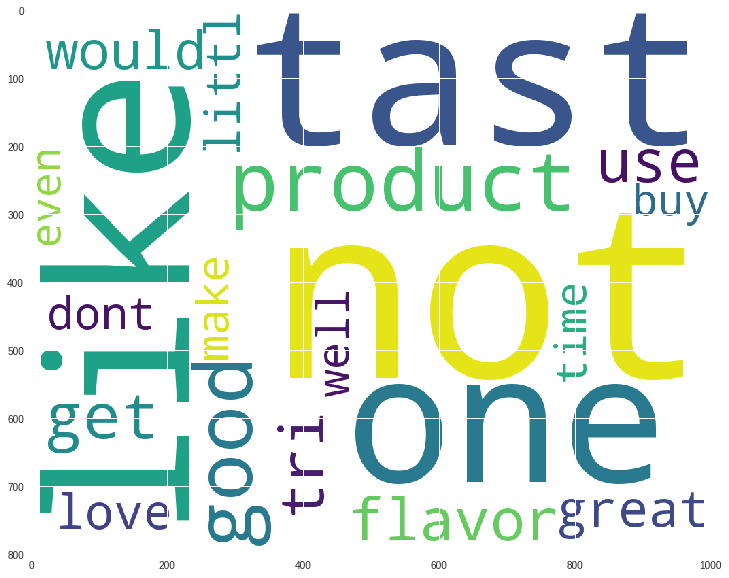

In [0]:
plt.figure( figsize=(20,10))
plt.imshow(wordcloud.WordCloud(background_color='white',width = 1000,height= 800).generate_from_frequencies(top_20))

<br>
<Br>
  <br>
  <br>

<Br>
  <br>
  
  ## FEATURIZATION 2 : TFIDF 

** Importing the data **

In [0]:
tf_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/train_tfidf.sav','rb'))
tf_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/cv_tfidf.sav','rb'))
tf_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/test_tfidf.sav','rb'))
y_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_train.sav','rb'))
y_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_test.sav','rb'))
y_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_cv.sav','rb'))
tfidf = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/tfidf.sav','rb'))

** CONCATENATING TRAIN AND CV  TO CREATE DATASET FOR CROSS VALIDATION** 

In [0]:
X_train = vstack([tf_train,tf_cv])
Y_train = pd.concat([y_train,y_cv],axis = 0,ignore_index = True)

In [0]:
X_train

<80000x29133 sparse matrix of type '<class 'numpy.float64'>'
	with 2424650 stored elements in Compressed Sparse Row format>

** PERFORMING GRID SEARCH **

** PARAM GRID : ** 

Constants:
1. Booster : Gbtree
2. eval-metric : auc

Variables: 

1. Learning Rate : 0.1,0.2,0.07,0.3
2. max Depth  : 4,5,6
3. N_estimators : 100,125,150,175,200,225,250,275,300
4. colsample_bytree :0.5,0.75


In [0]:
params = {'learning_rate':[0.07,0.1,0.2,0.3],'max_depth':[4,5,6],'n_estimators':[100,125,150,175,200,225,250,275,300],'colsample_bytree':[0.5,0.75]}

In [0]:
gridModel = GridSearchCV(estimator = xgb.XGBClassifier(booster = 'gbtree',eval_metric = 'auc'),param_grid = params,n_jobs =-1,scoring='roc_auc',verbose=True,cv = 2)

In [0]:
gridModel.fit(X_train,Y_train)

Fitting 2 folds for each of 216 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 70.4min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 187.4min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.07, 0.1, 0.2, 0.3], 'max_depth': [4, 5, 6], 'n_estimators': [100, 125, 150, 175, 200, 225, 250, 275, 300], 'colsample_bytree': [0.5, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [0]:
#best auc score 
gridModel.best_score_

0.9305696189889819

In [0]:
#best params 
gridModel.best_params_

{'colsample_bytree': 0.75,
 'learning_rate': 0.3,
 'max_depth': 4,
 'n_estimators': 300}

** Preparing the dataframe for visualisaiton ** 

In [0]:
results = pd.DataFrame(gridModel.cv_results_['params'])

In [0]:
results['Train_AUC_SCORE'] = gridModel.cv_results_['mean_train_score']
results['Test_AUC_SCORE'] = gridModel.cv_results_['mean_test_score']

** Analysis and visualisation of influence of various parameters on the AUC score ** 

** HEATMAP : TEST_AUC_SCORE **

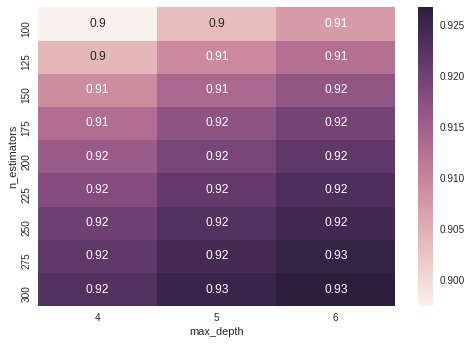

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Test_AUC_SCORE"),annot= True)

** HEATMAP : TRAIN_AUC_SCORE ** 

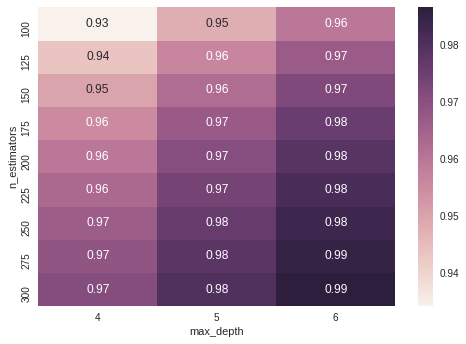

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Train_AUC_SCORE"),annot= True)

** IMPACT OF COLUMN SAMPLING AND LEARNING RATE ** 

In [0]:
results.groupby('learning_rate').aggregate(np.mean)[['Train_AUC_SCORE','Test_AUC_SCORE']]

,Train_AUC_SCORE,Test_AUC_SCORE
learning_rate,,
0.07,0.947032,0.904116
0.10,0.959471,0.913191
0.20,0.977500,0.923914
0.30,0.984740,0.926523


In [0]:
results.groupby('colsample_bytree').aggregate(np.mean)[['Train_AUC_SCORE','Test_AUC_SCORE']]

,Train_AUC_SCORE,Test_AUC_SCORE
colsample_bytree,,
0.50,0.966717,0.916787
0.75,0.967655,0.917085


In [0]:
pred = gridModel.predict(tf_test)
tpred = gridModel.predict(X_train)

In [0]:
print(classification_report(y_true=y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.81      0.51      0.62      2674
           1       0.93      0.98      0.95     17326

   micro avg       0.92      0.92      0.92     20000
   macro avg       0.87      0.75      0.79     20000
weighted avg       0.91      0.92      0.91     20000



In [0]:
print("TRAIN ERROR : " + str(1-(accuracy_score(y_true = Y_train,y_pred=tpred))))

TRAIN ERROR : 0.047137500000000054


In [0]:
print("TEST ERROR : " + str(1-(accuracy_score(y_true = y_test,y_pred=pred))))

TEST ERROR : 0.08184999999999998


** Observations :**

1. The train and test error difference are not very wide
2. There is a good overall F1 score of negative reviews.
3. Final Model : Grid Search Best estimators : max_depth  = 4, n_estimators = 300

** FINAL MODEL : **

In [0]:
model = xgb.XGBClassifier(max_depth = 4,n_estimators = 300,booster = 'gbtree',colsample_bytree=0.75,learning_rate = 0.3,objective = 'binary:logistic',eval_metric = 'auc') 
model.fit(X_train,Y_train)
pred = model.predict(tf_test)

In [0]:
tpred = model.predict(X_train)

In [0]:
print(classification_report(y_true = y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.81      0.51      0.62      2674
           1       0.93      0.98      0.95     17326

   micro avg       0.92      0.92      0.92     20000
   macro avg       0.87      0.75      0.79     20000
weighted avg       0.91      0.92      0.91     20000



** CONFUSION MATRIC : TEST  SET ** 

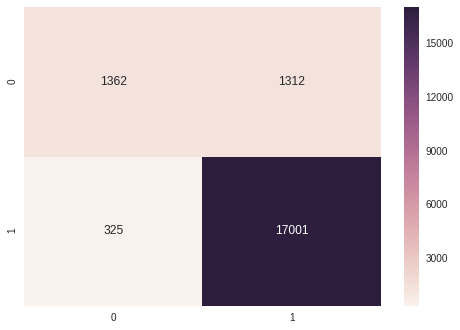

In [0]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred=pred),annot= True,fmt='d')

** CONFUSION MATRIX : TRAIN SET **

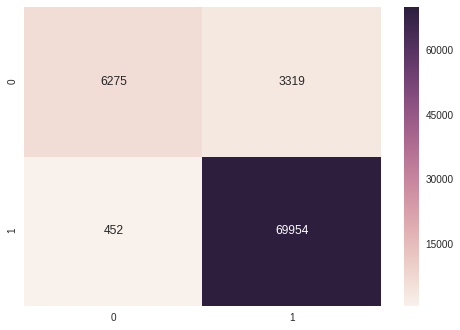

In [0]:
sns.heatmap(confusion_matrix(y_pred =tpred,y_true = Y_train),annot= True,fmt='d')

In [0]:
print("TRAIN ERROR : " + str(1-(accuracy_score(y_true = Y_train,y_pred=tpred))))

TRAIN ERROR : 0.047137500000000054


In [0]:
print("TEST ERROR : " + str(1-(accuracy_score(y_true = y_test,y_pred=pred))))

TEST ERROR : 0.08184999999999998


<br>
<br>
** FEATURE IMPORTANCE  : TFIDF **

In [0]:
features = tfidf.get_feature_names()

In [0]:
f_imp = dict(zip(features,model.feature_importances_))

In [0]:
top_20 = {}
for i in sorted(f_imp.items(), key=operator.itemgetter(1),reverse= True)[:20]:
  top_20[i[0]] = i[1]

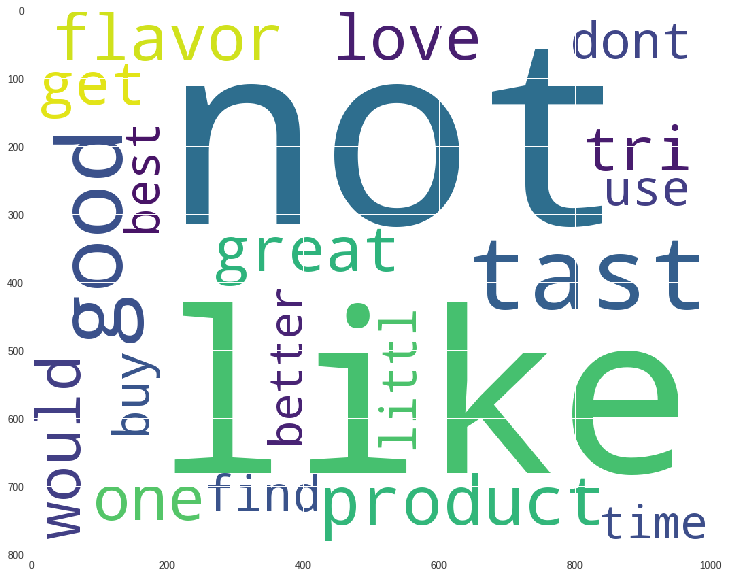

In [0]:
plt.figure( figsize=(20,10))
plt.imshow(wordcloud.WordCloud(background_color='white',width = 1000,height= 800).generate_from_frequencies(top_20))

<br>
<Br>
  <br>

## FEATURIZATION 3 : WORD2VEC

** Importing the data **

In [0]:
w2v_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/avg_word2vec_train.sav','rb'))
w2v_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/avg_word2vec_test.sav','rb'))

In [0]:
w2v_train.head()

,Vector 1,Vector 2,Vector 3,Vector 4,Vector 5,Vector 6,Vector 7,Vector 8,Vector 9,Vector 10,...,Vector 42,Vector 43,Vector 44,Vector 45,Vector 46,Vector 47,Vector 48,Vector 49,Vector 50,Score
0,0.121816,0.112731,0.522326,0.513944,0.014699,-0.510498,0.332466,-0.006182,0.510940,0.342244,...,-0.260098,-0.572254,-0.001088,0.079892,-0.092751,0.165952,0.354566,0.263851,-0.243470,1
1,0.317572,0.159626,0.343828,0.280532,0.477560,-0.579655,-0.058227,0.002837,0.070905,-0.068868,...,-0.401967,-0.649971,-0.189747,0.091126,-0.250324,-0.020535,0.567875,0.291098,-0.287811,1
2,0.113726,-0.240282,0.779548,0.906329,0.285768,-0.143818,0.310017,-0.139928,0.367076,0.384066,...,-0.153836,-0.216731,-0.155472,0.010060,-0.179123,0.395463,-0.208602,-0.294666,0.091154,1
3,0.601365,0.113279,0.712399,0.237966,0.321083,-0.329348,0.301765,-0.035661,0.460765,-0.075949,...,-0.091186,-0.206183,0.062646,0.104041,0.018641,0.299300,-0.000715,-0.171055,-0.046017,1
4,0.110524,-0.161300,0.858878,1.161848,0.425219,-0.414926,0.006795,-0.259896,0.324213,0.731779,...,-0.187014,-0.071594,-0.525720,0.221244,-0.213230,0.498298,-0.212721,-0.079328,0.490372,1


** Separating the X and Y from the datasets (train and test) ** 
1. X : Vectors 1 to 50 
2. Y : Target  Variable 

In [0]:
X_train = w2v_train.iloc[:,0:50].copy(deep=True)
X_test = w2v_test.iloc[:,0:50].copy(deep=True)
y_train = w2v_train['Score']
y_test = w2v_test['Score']

** PARAMETERS TO TUNE : ** 

** PARAM GRID : ** 

Constants:
1. Booster : Gbtree
2. eval-metric : auc

Variables: 

1. Learning Rate : 0.1,0.2,0.07,0.3
2. max Depth  : 4,5,6
3. N_estimators : 100,125,150,175,200,225,250,275,300
4. colsample_bytree :0.5,0.75

In [0]:
params = {'learning_rate':[0.07,0.1,0.2,0.3],'max_depth':[4,5,6],'n_estimators':[100,125,150,175,200,225,250,275,300],'colsample_bytree':[0.5,0.75]}

In [0]:
gridModel = GridSearchCV(estimator = xgb.XGBClassifier(booster = 'gbtree',eval_metric = 'auc'),param_grid = params,n_jobs =-1,scoring='roc_auc',verbose=True,cv = 2)

In [0]:
gridModel.fit(X_train,y_train)

Fitting 2 folds for each of 216 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 47.7min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 127.4min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.07, 0.1, 0.2, 0.3], 'max_depth': [4, 5, 6], 'n_estimators': [100, 125, 150, 175, 200, 225, 250, 275, 300], 'colsample_bytree': [0.5, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [0]:
#best auc score 
gridModel.best_score_

0.9025413888082446

In [0]:
#best params 
gridModel.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.07,
 'max_depth': 5,
 'n_estimators': 300}

** Preparing the dataframe for visualisaiton ** 

In [0]:
results = pd.DataFrame(gridModel.cv_results_['params'])

In [0]:
results['Train_AUC_SCORE'] = gridModel.cv_results_['mean_train_score']
results['Test_AUC_SCORE'] = gridModel.cv_results_['mean_test_score']

** Analysis and visualisation of influence of various parameters on the AUC score ** 

** HEATMAP : TEST_AUC_SCORE **

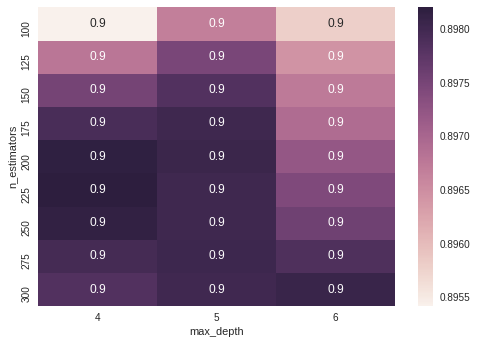

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Test_AUC_SCORE"),annot= True)

** HEATMAP : TRAIN_AUC_SCORE ** 

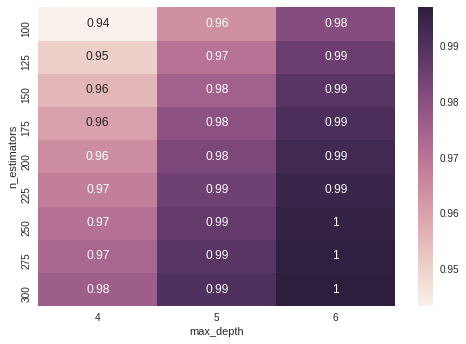

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Train_AUC_SCORE"),annot= True)

** IMPACT OF COLUMN SAMPLING AND LEARNING RATE ** 

In [0]:
results.groupby('learning_rate').aggregate(np.mean)[['Train_AUC_SCORE','Test_AUC_SCORE']]

,Train_AUC_SCORE,Test_AUC_SCORE
learning_rate,,
0.07,0.961982,0.899646
0.10,0.971348,0.900436
0.20,0.986393,0.897212
0.30,0.992421,0.892671


In [0]:
results.groupby('colsample_bytree').aggregate(np.mean)[['Train_AUC_SCORE','Test_AUC_SCORE']]

,Train_AUC_SCORE,Test_AUC_SCORE
colsample_bytree,,
0.50,0.977543,0.897708
0.75,0.978529,0.897275


In [0]:
pred = gridModel.predict(X_test)
tpred = gridModel.predict(X_train)

In [0]:
print(classification_report(y_true=y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.74      0.42      0.54      4101
           1       0.91      0.98      0.94     25899

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.83      0.70      0.74     30000
weighted avg       0.89      0.90      0.89     30000



In [0]:
print("TRAIN ERROR : " + str(1-(accuracy_score(y_true = y_train,y_pred=tpred))))

TRAIN ERROR : 0.0652571428571429


In [0]:
print("TEST ERROR : " + str(1-(accuracy_score(y_true = y_test,y_pred=pred))))

TEST ERROR : 0.09926666666666661


** Observations : **

1. The model with max Depth with 6 and very high number of base learners are overfitting as they have 100%  99% Train AUC score and Test AUC score is around 90% which is almost 10% difference.
2.  We can go with max depth of 5 by tapping the learning rate : making it 0.07 where there will be less difference.
3. Final model : Max- Depth = 5, n-estimators = 300 and  Learning rate : 0.07

** FINAL MODEL : **

In [0]:
model = xgb.XGBClassifier(max_depth = 5,n_estimators = 300,booster = 'gbtree',colsample_bytree=0.5,learning_rate = 0.07,objective = 'binary:logistic',eval_metric = 'auc') 
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [0]:
tpred = model.predict(X_train)

In [0]:
print(classification_report(y_true = y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.74      0.42      0.54      4101
           1       0.91      0.98      0.94     25899

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.83      0.70      0.74     30000
weighted avg       0.89      0.90      0.89     30000



** CONFUSION MATRIC : TEST  SET ** 

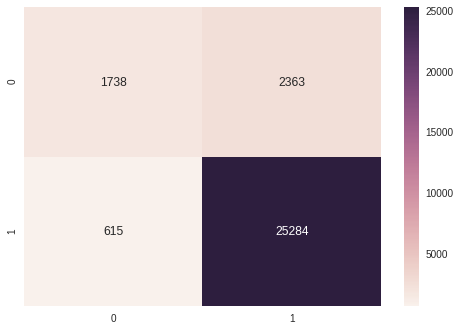

In [0]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred=pred),annot= True,fmt='d')

** CONFUSION MATRIX : TRAIN SET **

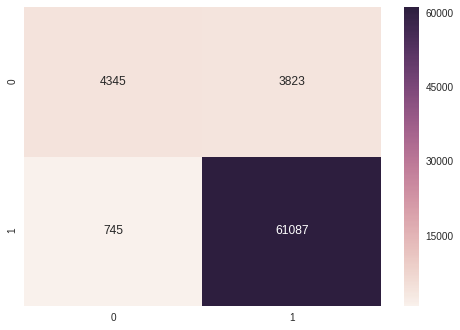

In [0]:
sns.heatmap(confusion_matrix(y_pred =tpred,y_true = y_train),annot= True,fmt='d')

In [0]:
print("TRAIN ERROR : " + str(1-(accuracy_score(y_true = y_train,y_pred=tpred))))

TRAIN ERROR : 0.0652571428571429


In [0]:
print("TEST ERROR : " + str(1-(accuracy_score(y_true = y_test,y_pred=pred))))

TEST ERROR : 0.09926666666666661


<br>
<Br>
  <br>

<Br>
  <br>
  
  ## FEATURIZATION 4: TFIDF WORD2VEC

** Importing the data **

In [0]:
tfw2v_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/Train_TFW2V.sav','rb'))
tfw2v_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/Test_TFW2V.sav','rb'))

In [0]:
X_train = tfw2v_train.iloc[:,0:50].copy(deep=True)
X_test = tfw2v_test.iloc[:,0:50].copy(deep=True)
y_train = tfw2v_train['Score']

y_test = tfw2v_test['Score']

** PERFORMING GRID SEARCH **

** PARAM GRID : ** 

Constants:
1. Booster : Gbtree
2. eval-metric : auc

Variables: 

1. Learning Rate : 0.1,0.2,0.07,0.3
2. max Depth  : 4,5,6
3. N_estimators : 100,125,150,175,200,225,250,275,300
4. colsample_bytree :0.5,0.75

In [0]:
params = {'learning_rate':[0.07,0.1,0.2],'max_depth':[4,5,6],'n_estimators':[150,175,200,225,250,275,300],'colsample_bytree':[0.5,0.75]}

In [0]:
gridModel = GridSearchCV(estimator = xgb.XGBClassifier(booster = 'gbtree',eval_metric = 'auc'),param_grid = params,n_jobs =-1,scoring='roc_auc',verbose=True,cv = 2)

In [0]:
gridModel.fit(X_train,y_train)

Fitting 2 folds for each of 126 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 62.3min
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed: 84.9min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.07, 0.1, 0.2], 'max_depth': [4, 5, 6], 'n_estimators': [150, 175, 200, 225, 250, 275, 300], 'colsample_bytree': [0.5, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [0]:
#best auc score 
gridModel.best_score_

0.8752933527884917

In [0]:
#best params 
gridModel.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.07,
 'max_depth': 6,
 'n_estimators': 300}

** Preparing the dataframe for visualisaiton ** 

In [0]:
results = pd.DataFrame(gridModel.cv_results_['params'])

In [0]:
results['Train_AUC_SCORE'] = gridModel.cv_results_['mean_train_score']
results['Test_AUC_SCORE'] = gridModel.cv_results_['mean_test_score']

** Analysis and visualisation of influence of various parameters on the AUC score ** 

** HEATMAP : TEST_AUC_SCORE **

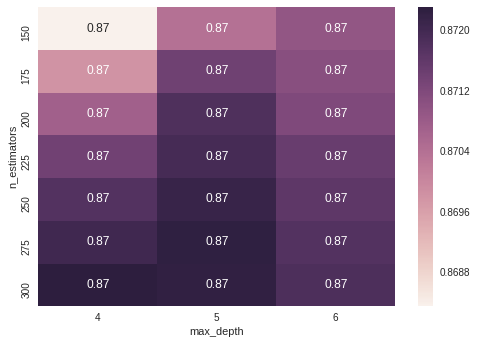

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Test_AUC_SCORE"),annot= True)

** HEATMAP : TRAIN_AUC_SCORE ** 

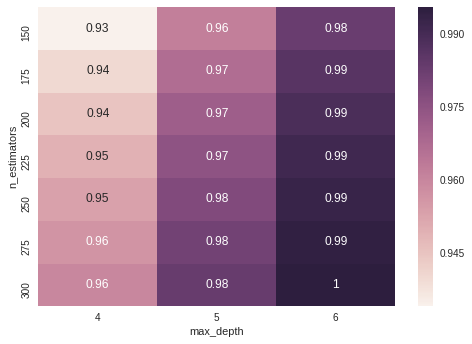

In [0]:
sns.heatmap(results.pivot_table(index = "n_estimators",columns = "max_depth",values = "Train_AUC_SCORE"),annot= True)

** IMPACT OF COLUMN SAMPLING AND LEARNING RATE ** 

In [0]:
results.groupby('learning_rate').aggregate(np.mean)[['Train_AUC_SCORE','Test_AUC_SCORE']]

,Train_AUC_SCORE,Test_AUC_SCORE
learning_rate,,
0.07,0.957886,0.872250
0.10,0.968681,0.872861
0.20,0.985908,0.868978


In [0]:
results.groupby('colsample_bytree').aggregate(np.mean)[['Train_AUC_SCORE','Test_AUC_SCORE']]

,Train_AUC_SCORE,Test_AUC_SCORE
colsample_bytree,,
0.50,0.970173,0.871320
0.75,0.971477,0.871407


In [0]:
pred = gridModel.predict(X_test)
tpred = gridModel.predict(X_train)

In [0]:
print(classification_report(y_true=y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.73      0.34      0.46      4101
           1       0.90      0.98      0.94     25899

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.82      0.66      0.70     30000
weighted avg       0.88      0.89      0.87     30000



** Observations : **

1. There is no significant difference between the test auc scores for different models

In [0]:
print("TRAIN ERROR : " + str(1-(accuracy_score(y_true = y_train,y_pred=tpred))))

TRAIN ERROR : 0.059528571428571375


In [0]:
print("TEST ERROR : " + str(1-(accuracy_score(y_true = y_test,y_pred=pred))))

TEST ERROR : 0.10773333333333335


** Observations : ** 

1. There is significant difference of 4% between the train and test error. As almost all the classifiers give similar performance in the test CV , we have to see other low N-estimators to reduce the difference between train and test error.
2. Metrics to see : Recall , Precision  and erro difference 

** Constants: ** 

1. max Depth = 6
2. Learning Rate = 0.2
3. ColSample By Tree = 0.75

In [0]:
recall = {}
precision = {}
diff = {}
#keeping max Depth , learning rate and col sample bytree
for i in [150,175,200,225,250,275,300]:
  print("Training for n_estimators = " + str(i) + "\n")
  model = xgb.XGBClassifier(max_depth = 6,n_estimators = i,booster = 'gbtree',colsample_bytree=0.75,learning_rate = 0.2,objective = 'binary:logistic',eval_metric = 'auc')
  model.fit(X_train,y_train)
  pred = model.predict(X_test)
  test_error = (1 - accuracy_score(y_true = y_test,y_pred=pred)) * 100
  train_error = (1 - accuracy_score(y_true = y_train,y_pred=model.predict(X_train))) * 100
  recall[i] = recall_score(y_true = y_test,y_pred = pred,pos_label = 0) * 100
  precision[i] = precision_score(y_true =y_test,y_pred = pred,pos_label = 0) * 100 
  diff[i] = test_error-train_error

Training for n_estimators = 150

Training for n_estimators = 175

Training for n_estimators = 200

Training for n_estimators = 225

Training for n_estimators = 250

Training for n_estimators = 275

Training for n_estimators = 300



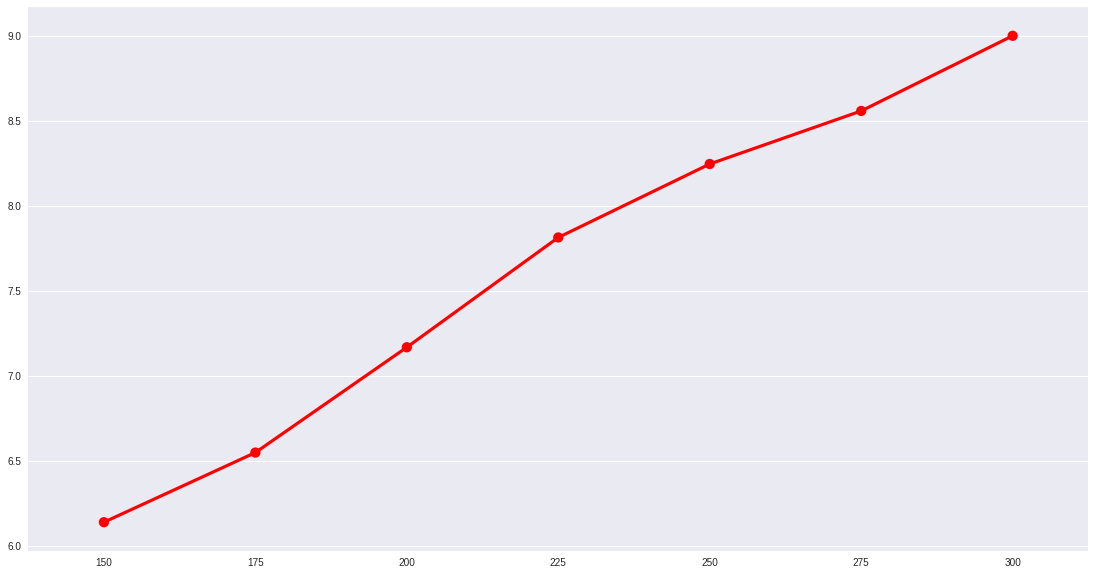

In [0]:
plt.figure(figsize = (19,10))
sns.pointplot(list(diff.keys()),list(diff.values()),color = 'red')

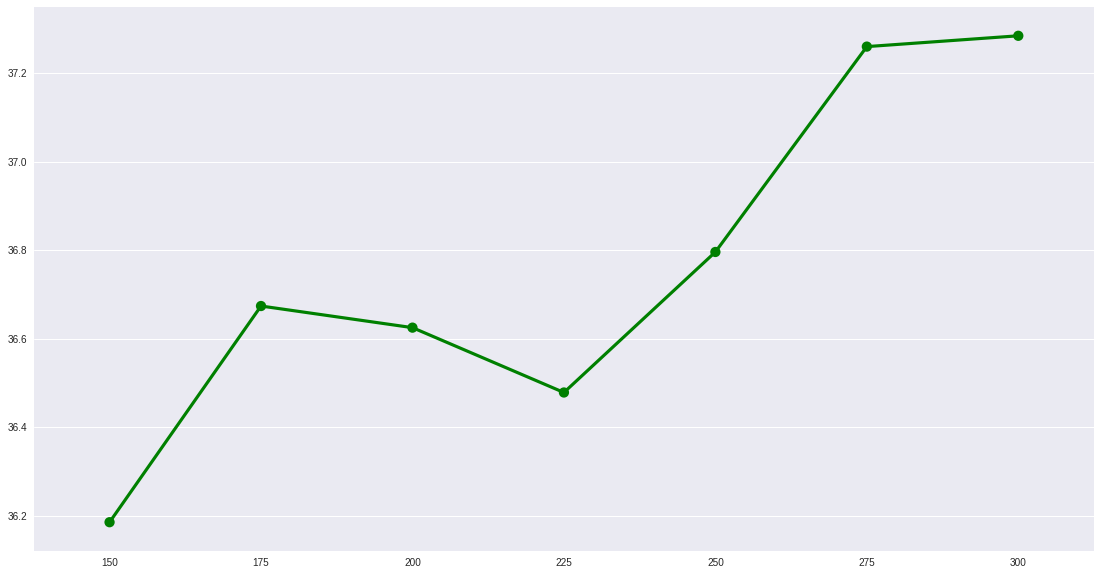

In [0]:
plt.figure(figsize = (19,10))
sns.pointplot(list(recall.keys()),list(recall.values()),color = 'green')

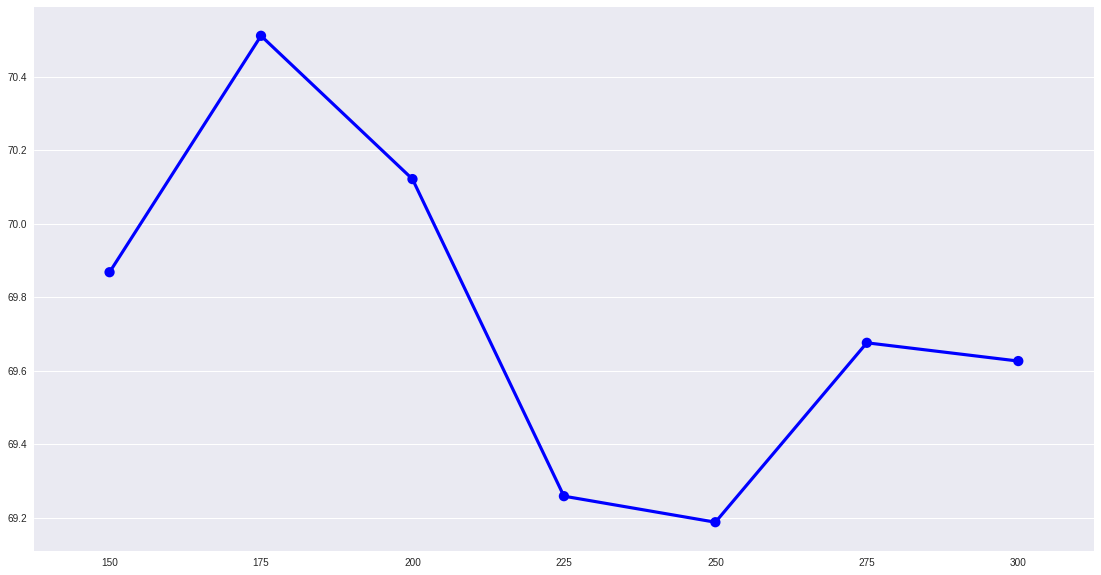

In [0]:
plt.figure(figsize = (19,10))
sns.pointplot(list(precision.keys()),list(precision.values()),color = 'blue')

** Observations ** :
1. The precision and recall do not improve drastically as N-estimators increase from 200 to 300. 
2. But the difference between the train and test error increase drastically as n-estimators increase.
3. Precision is high at the N-estimator  =175 and corresponding is recall is also considerably good.
4. Final Model max-depth = 6, n_estimators = 175

** FINAL MODEL **

In [0]:
model = xgb.XGBClassifier(max_depth = 6,n_estimators = 175,booster = 'gbtree',colsample_bytree=0.75,learning_rate = 0.07,objective = 'binary:logistic',eval_metric = 'auc') 
model.fit(X_train,Y_train)
pred = model.predict(X_test)

In [0]:
tpred = model.predict(X_train)

In [0]:
print(classification_report(y_true = y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.72      0.32      0.44      4101
           1       0.90      0.98      0.94     25899

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.81      0.65      0.69     30000
weighted avg       0.88      0.89      0.87     30000



** CONFUSION MATRIC : TEST  SET ** 

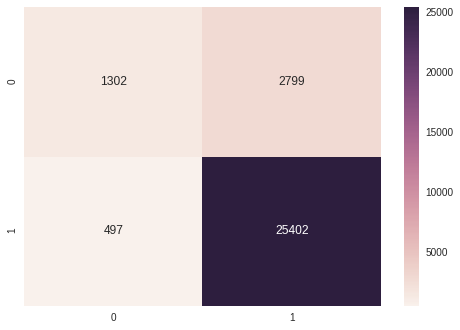

In [0]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred=pred),annot= True,fmt='d')

** CONFUSION MATRIX : TRAIN SET **

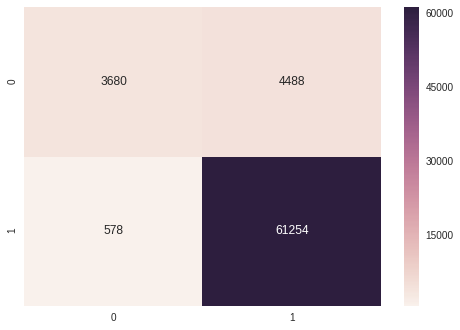

In [0]:
sns.heatmap(confusion_matrix(y_pred =tpred,y_true = Y_train),annot= True,fmt='d')

In [0]:
print("TRAIN ERROR : " + str(1-(accuracy_score(y_true = Y_train,y_pred=tpred))))

TRAIN ERROR : 0.07237142857142853


In [0]:
print("TEST ERROR : " + str(1-(accuracy_score(y_true = y_test,y_pred=pred))))

TEST ERROR : 0.10986666666666667


<br>
<Br>
  <Br>



---


## SUMMARY

<br>
<Br>



|FEATURIZATION| MAX-DEPTH | N_ESTIMATORS|LEARNING RATE |COLUMN RATIO |ACCURACY  | AUC SCORE |TRAIN ERROR | TEST ERROR | DIFFERENCE|
|------|------|-----|-----|----|----|----|----|
|BOW|5|300|0.2|0.75|91.8| 92.81 | 5.3|8.2 | 2.9|
|TFIDF|4|300|0.3|0.75|91.9|93.06| 4.7 | 8.1 | 3.4|
|WORD2VEC|5|300|0.07|0.5|90.2|90.254|6.52|9.92|3.4|
|TFIDF WORD2VEC|6|175|0.07|0.75|89.1|87.529|7.23|10.9|3.67|